In [1]:
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import pandas as pd


from evaluate import load_data, load_model_checkpoint, plot_results
from utils import calculate_random_walk_matrix
from model_sigformer import SIGFormer

import scienceplots

plt.style.use(['science','nature','no-latex'])
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

def set_global_seed(seed=1):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [2]:
def load_data(dataset):
    """
    Load dataset.
    Input: dataset name
    Returns:
    -------
    A: adjacency matrix 
    X: processed data
    capacity: only works for NREL, each station's capacity
    """
    A = np.load('data/pems_flow/adj_mat.npy')
    X = np.load('data/pems_flow/node_values.npy').transpose()

    A = np.array(A, dtype=np.float32)
    X = np.array(X, dtype=np.float32)

    split_line1 = int(X.shape[1] * 0.6)
    split_line2 = int(X.shape[1] * 0.8)

    training_set = X[:, :split_line1].transpose()
    val_set = X[:, split_line1:split_line2].transpose()
    test_set = X[:, split_line2:].transpose()
    print('training_set',training_set.shape)
    print('validation_set',val_set.shape)
    print('test_set',test_set.shape)

    full_set = set(range(X.shape[0]))
    return A, X, training_set, test_set, full_set


def load_trained_model(model_path, h, z, K, device):
    """
    Load the trained model from the specified path.
    """
    # model = SIGFormer(h, z, K, L=1, heads=4, ff_hidden_dim=128)
    model = SIGFormer(h, z, K, L=1, heads=4, heads_temp=1, ff_hidden_dim=128)
    model.load_state_dict(torch.load(model_path, map_location=device, weights_only=False))
    model.to(device)
    model.eval()
    return model


def evaluate_model(model, A, test_set, unknow_set, E_maxvalue, device):
    """
    Evaluate the model on the test set.
    """
    unknow_set = set(unknow_set)
    time_dim = model.time_dimension

    test_omask = np.ones(test_set.shape)
    test_omask[test_set == 0] = 0
    test_inputs = (test_set * test_omask).astype('float32')

    missing_index = np.ones(np.shape(test_set))
    missing_index[:, list(unknow_set)] = 0

    o = np.zeros([test_set.shape[0] // time_dim * time_dim, test_inputs.shape[1]])

    for i in range(0, test_set.shape[0] // time_dim * time_dim, time_dim):
        inputs = test_inputs[i:i + time_dim, :]
        missing_inputs = missing_index[i:i + time_dim, :]
        T_inputs = inputs * missing_inputs
        T_inputs = T_inputs / E_maxvalue
        T_inputs = np.expand_dims(T_inputs, axis=0)
        T_inputs = torch.from_numpy(T_inputs.astype('float32')).to(device)
        A_q = torch.from_numpy((calculate_random_walk_matrix(A).T).astype('float32')).to(device)
        A_h = torch.from_numpy((calculate_random_walk_matrix(A.T).T).astype('float32')).to(device)

        imputation = model(T_inputs, A_q, A_h)
        imputation = imputation.cuda().data.cpu().numpy()
        o[i:i + time_dim, :] = imputation[0, :, :]

    o = o * E_maxvalue

    return o

In [3]:
# Define parameters
dataset = "pems_flow"
h = 24
z = 128
K = 1
E_maxvalue = 220
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load dataset and unknown set
A, X, training_set, test_set, full_set = load_data(dataset)

# Directory containing trained models
models_dir = "checkpoints/SIGFormer_pems_flow/"

R_I = [0.2, 0.4, 0.6, 0.8]
R_M = [0.2, 0.4, 0.6, 0.8]
R_I_ = ['20%', '40%', '60%', '80%']
patterns = ['cs', 's', 't', 'b', 'r']
pattern = 'cs'
data_mae = []
data_rmse = []

for ii in range(10):
    MAE = {}
    RMSE = {}
    for i in range(len(R_I)):
        r_i = R_I[i]
        print('Iteration '+str(ii)+', r_i: '+str(r_i))

        unknow_set = set(random.sample(range(test_set.shape[1]), int(r_i * test_set.shape[1])))
        # Storage for reconstructed data and model names
        reconstructed_models = []
        model_names = []

        # Iterate over all trained models in the results folder
        for root, _, files in os.walk(models_dir):
            mae_list = {}
            rmse_list = {}

            for r_m in R_M:
                model_name = f"best_model_p={pattern}_r_m={r_m:.2f}.pth"
                model_path = os.path.join(root, model_name)
                
                print(f"Evaluating model: {model_name}")
                # Load the model
                model = load_trained_model(model_path, h, z, K, device)

                # Evaluate the model
                reconstructed = evaluate_model(model, A, test_set, unknow_set, E_maxvalue, device)

                # Store results
                reconstructed_models.append(reconstructed)
                model_names.append(model_name)

                gt = test_set[:reconstructed.shape[0]]
                rec = reconstructed

                mae = np.mean(np.abs(gt - rec))
                rmse = np.sqrt(np.mean(np.square(gt - rec)))
                print('Pattern:', pattern, ', r_m:', r_m, ', MAE:', mae, ', RMSE:', rmse)
                mae_list[r_m] = [mae]
                rmse_list[r_m] = [rmse]
        MAE[R_I[i]] = mae_list
        RMSE[R_I[i]] = rmse_list
    data_mae.append(MAE)
    data_rmse.append(RMSE)


print(data_mae)
print(data_rmse)

training_set (10540, 205)
validation_set (3514, 205)
test_set (3514, 205)
Iteration 0, r_i: 0.2
Evaluating model: best_model_p=cs_r_m=0.20.pth
Pattern: cs , r_m: 0.2 , MAE: 8.914118672583365 , RMSE: 13.807755142354385
Evaluating model: best_model_p=cs_r_m=0.40.pth
Pattern: cs , r_m: 0.4 , MAE: 10.205746052779862 , RMSE: 15.235287155712465
Evaluating model: best_model_p=cs_r_m=0.60.pth
Pattern: cs , r_m: 0.6 , MAE: 11.82985733484229 , RMSE: 16.65342895624915
Evaluating model: best_model_p=cs_r_m=0.80.pth
Pattern: cs , r_m: 0.8 , MAE: 20.69533018576121 , RMSE: 26.1903185497531
Iteration 0, r_i: 0.4
Evaluating model: best_model_p=cs_r_m=0.20.pth
Pattern: cs , r_m: 0.2 , MAE: 10.083084349086178 , RMSE: 14.973129437424648
Evaluating model: best_model_p=cs_r_m=0.40.pth
Pattern: cs , r_m: 0.4 , MAE: 10.735975695640946 , RMSE: 15.631360457484819
Evaluating model: best_model_p=cs_r_m=0.60.pth
Pattern: cs , r_m: 0.6 , MAE: 11.079471384855685 , RMSE: 15.70797753396341
Evaluating model: best_model

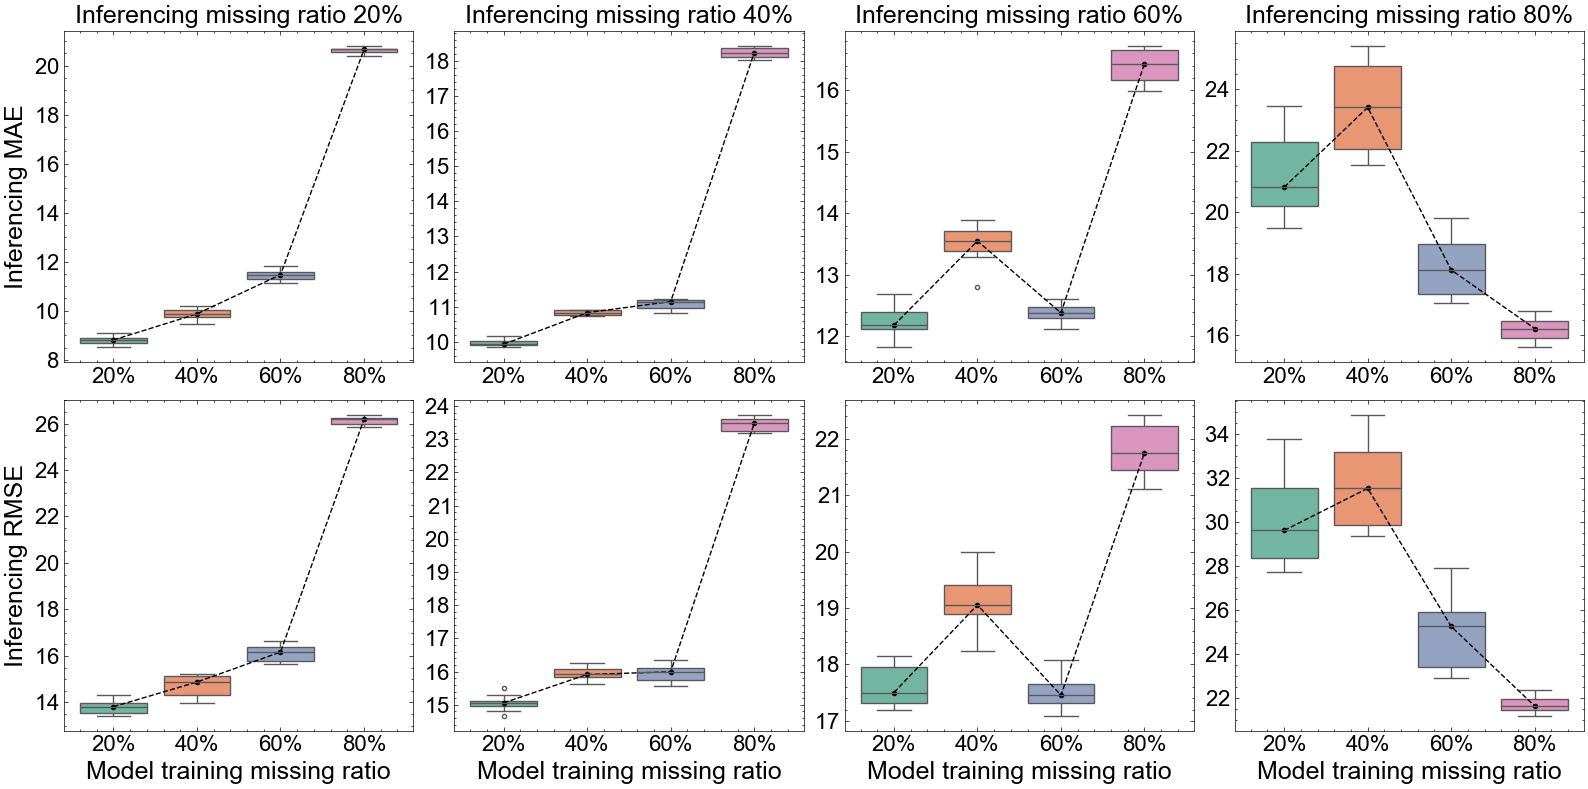

In [4]:
# Initialize lists for storing long-format data
mae_data = []
rmse_data = []

# Process each dictionary in the list
for i in range(10):  # Assuming 10 sets of input data
    mae_dict = data_mae[i]
    rmse_dict = data_rmse[i]
    
    for inference_ratio, missing_data in mae_dict.items():
        for missing_ratio, values in missing_data.items():
            mae_data.append((f"{int(inference_ratio*100)}%", f"{int(missing_ratio*100)}%", values[0]))  # Single value
            rmse_data.append((f"{int(inference_ratio*100)}%", f"{int(missing_ratio*100)}%", rmse_dict[inference_ratio][missing_ratio][0]))  # Single value

# Convert to DataFrames
mae_df = pd.DataFrame(mae_data, columns=['Inference Ratio', 'Missing Ratio', 'MAE'])
rmse_df = pd.DataFrame(rmse_data, columns=['Inference Ratio', 'Missing Ratio', 'RMSE'])

# Define color palette and line color
colors = sns.color_palette("Set2", 4)
line_color = "black"

# Plotting the 2x4 layout of box plots
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# mae_ylim = (0, 40)
# rmse_ylim = (0, 50)

# Creating box plots for each inference ratio and metric
for i, inference_ratio in enumerate(mae_df['Inference Ratio'].unique()):
    # MAE box plot
    sns.boxplot(
        x='Missing Ratio', y='MAE', data=mae_df[mae_df['Inference Ratio'] == inference_ratio],
        hue='Missing Ratio', palette=colors, ax=axes[0, i], legend=False
    )
    
    # Median line connection for MAE
    mae_values = mae_df[mae_df['Inference Ratio'] == inference_ratio].groupby('Missing Ratio')['MAE'].median()
    axes[0, i].plot(range(len(mae_values)), mae_values, marker='o', color=line_color, linestyle='--')

    
    # Title and labels
    axes[0, i].set_title(f'Inferencing missing ratio {inference_ratio}', fontsize=18)
    if i == 0:
        axes[0, i].set_ylabel('Inferencing MAE', fontsize=18)
    else:
        axes[0, i].set_ylabel('')
    axes[0, i].set_xlabel('')
    axes[0, i].yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    axes[0, i].tick_params(axis='both', labelsize=16)
    axes[0, i].yaxis.set_major_locator(plt.MaxNLocator(integer=True))


    # RMSE box plot
    sns.boxplot(
        x='Missing Ratio', y='RMSE', data=rmse_df[rmse_df['Inference Ratio'] == inference_ratio],
        hue='Missing Ratio', palette=colors, ax=axes[1, i], legend=False
    )
    
    # Median line connection for RMSE
    rmse_values = rmse_df[rmse_df['Inference Ratio'] == inference_ratio].groupby('Missing Ratio')['RMSE'].median()
    axes[1, i].plot(range(len(rmse_values)), rmse_values, marker='o', color=line_color, linestyle='--')
    axes[1, i].set_xlabel('Model training missing ratio', fontsize=18)
    
    # Only keep y labels for the first column
    if i == 0:
        axes[1, i].set_ylabel('Inferencing RMSE', fontsize=18)
    else:
        axes[1, i].set_ylabel('')
    axes[1, i].yaxis.set_major_locator(plt.MaxNLocator(integer=True))# Set y-limits and font size for y-ticks
    # axes[1, i].set_ylim(rmse_ylim)
    axes[1, i].tick_params(axis='both', labelsize=16)
    axes[1, i].yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()
